Simulation for branching process with random mutation. Each time the pathogen transmits to a new person, it mutates (both beta and gamma are allowed to mutate independently).

There are 2 main functions, "sim" and "recurrent_sim".

"sim" represents a process without recurrent spillover. It seeds the population with an initial case (presumably spilled over from a reservoir). It branches until either the infection goes extinct or surpasses a threshold. In the latter case, we call it an outbreak. 

"recurrent_sim" represents a process with random recurrent spillover at some rate alpha. It begins with a single founding spillover case and branches it. Meanwhile, more spillovers arrive, each giving birth to a new branching process tree. Overall, the infection either surpasses an outbreak threshold, or it goes extinct (which requires a moment in time when ALL spillover processes have gone extinct - i.e. there are 0 infected people at that time). 

To dos: 
    - Make more graphs/visualizations.
    - Play with mutation rates.
            - Play with unequal mutation rates for beta and gamma
    - Merge or replace sim with sim_plots (but make it better first)
    - Play with spillover rate.
    - Include backwards transmission.
    - Try with a finite population.
    - Create class for return value of simulation
    - Improve commenting for treatment of cases where beta=gamma=0 as a result of mutation.
    - Improve implementation of branching order, or of N_infecteds count.
    - Do a sanity check for the implementation of interevent time against Linda's slides.
    - Do a sanity check for the bulk recurrent simulation against the Voinson 2018 paper.

In [1441]:
import numpy as np
import matplotlib.pyplot as plt

In [1507]:
###################################################
# simulates infection WITHOUT recurrent spillover #
# allows both gamma and beta to mutate            #
###################################################
#
# input beta_0 is transmission rate of the initial case.
# input gamma_0 is recovery rate of the initial case. 
#
# optional input mu_1 represents mutation rate for beta. If unspecified, defaults to 0.
# optional input mu_2 represents mutation rate for gamma. If unspecified, defaults to 0.
#
###################################################
#
# returns [0, t_ext] if extinction, where t_ext is time of extinction. 
# returns [1] if outbreak
#
###################################################

def sim(beta_0, gamma_0, mu_1=0, mu_2=0):
    
    outbreak_thresh = 100 #call it an outbreak if this many people are infected
    
    #store active cases as an array of triples
    #each triple looks like [beta, gamma, time of infection] and represents one infected person
    infecteds=np.array([[beta_0, gamma_0, 0]])
    N_infected = 1 #keep track of number of infected people. 
    
    t_ext = None #time of extinction, will fill this value and return it if the infection goes extinct
    
    while True: 
        
        #print("\n", "infecteds now = ", infecteds)
        
        person = infecteds[0] #branch person 0. note infecteds is maintained in order of increasing time of infection. 
        [beta, gamma, t] = person
        #print("\n", "branching person who was infected at time", t)

        while True: #branch person 0 until they recover.
                
            #we might sometimes run into a person with beta = gamma = 0, as a result of mutation. 
            #in this case the next part would throw a divide by 0 error. 
            #this is a person who never transmits and never recovers, so we should just delete them
            #we will also subtract 1 from N_infected, in order to avoid throwing other errors. 
            #in all, this treats them just as if they recovered. maybe think of a better way to deal with this in the future.
#             if beta == 0 and gamma == 0:
                
#                 #print('deleting someone with beta=gamma=0')
                
#                 infecteds = np.delete(infecteds, 0, axis=0)
#                 N_infected -= 1
#                 if N_infected == 0:
#                     t_ext = new_t #time of extinction
#                     return [0, t_ext]
#                 break #skip to next person

            #interevent time
            #note this is interevent time for ONE person, NOT for entire population
            dt = np.random.exponential(scale=1/(beta + gamma))
            new_t = t + dt

            #pick which event happens, transmission or recovery         
            ev = np.random.rand() #draw number from uniform distribution over [0, 1)
            prob_trans = beta / (beta+gamma) #probability of transmission

            if (ev < prob_trans): #transmission

                #print("transmitting")

                #pick beta and gamma for new case
                #mutation is a number drawn from normal distribution with std dev mu_1 or mu_2
                #don't allow negative beta.
                #don't allow gamma to be less than a small value, the natural death rate.
                mut1 = np.random.normal(loc=0.0, scale=mu_1)
                new_beta = max(0, beta + mut1)
                mut2 = np.random.normal(loc=0.0, scale=mu_2)              
                nat_death = 0.00002366575 #taken from CDC: https://www.cdc.gov/nchs/fastats/deaths.htm & scaled to be daily rate instead of yearly
                new_gamma = max(nat_death, gamma + mut2)

                N_infected += 1
                
                #print(N_infected)

                #check if we have an outbreak
                if N_infected >= outbreak_thresh:
                    
                    #print("\n", "outbreak!")
                    
                    return [1]

                #append new person to array of infecteds
                infecteds = np.append(infecteds, [[new_beta, new_gamma, new_t]], axis=0)
                
                #print("new infection: ", [new_beta, new_gamma, new_t])

            else: #recovery

                #print("recovering") 

                N_infected -= 1
                
                #print(N_infected)

                #check if we have extinction       
                if N_infected == 0:
                    t_ext = new_t #time of extinction
                    
                    #print("\n", "extinction")
                    
                    return [0, t_ext]

                #delete the person 
                infecteds = np.delete(infecteds, 0, axis=0)
                
                #print('deleted person')
                
                break #skip to next person

            #sort the array of infecteds in increasing order of time infected. 
            sorted_indices = np.argsort(infecteds[:,2])
            infecteds = infecteds[sorted_indices]        
            

In [1508]:
###########################
# run a single simulation #
###########################

#parameters
beta_0 = 0.09
gamma_0 = 0.1
mu_1 = 0.01
mu_2 = 0.01

sim(beta_0, gamma_0, mu_1, mu_2)

[0, 3.258690355242661]

In [1509]:
#########################
# runs many simulations #
#########################
#
# optional input N_sims is number of simulations to run.
#
# returns the percentage of those simulations that outbreak
#
#########################

def sim_percentage(beta_0, gamma_0, mu_1=0, mu_2=0, N_sims=200):
    
    N_outbreaks = 0
    
    for i in range(N_sims):
        if sim(beta_0, gamma_0, mu_1, mu_2) == [1]: N_outbreaks += 1
    return N_outbreaks/N_sims

In [1510]:
# This cell takes several minutes to run.

################
# SANITY CHECK #
################
#
# When there is no mutation, check that our simulation agrees with known results.
# From Linda's talk: the correct probability of outbreak is:
#
#                            0 if R_0 < 1
#                            1-1/R_0 = 1-gamma/beta if R_0 > 1
#
################

# Take some evenly spaced R_0 values from 0.01 to 2.5
beta_range = np.linspace(0.001, 0.25, 100)
gamma = 0.1

R0 = []
percent = []

#simulate percentages of outbreak
for beta in beta_range:
    R0 = np.append(R0, beta/gamma)
    percent = np.append(percent, sim_percentage(beta, gamma, N_sims=1000)) #default mutation rates are 0

KeyboardInterrupt: 

In [ ]:
#plot the result of the previous cell
plt.plot(R0, percent, "ob")

#graph actual probability of outbreak
plt.plot(R0, 1-1/R0, "r", label='actual probability')

plt.title('Sanity Check, mu1 = mu2 = 0')
plt.xlabel("R_0")
plt.ylabel("p")
plt.xlim(0, 2.5)
plt.ylim(0, 0.6)
plt.legend()
plt.show()

The next two cells plot percentage of outbreaks against R_0, when mu_1 = mu_2 = 0.001

In [1364]:
# This cell takes several minutes to run.

mu_1 = 0.001
mu_2 = 0.001

# Take a some evenly spaced R_0 values from 0.01 to 2.5
beta_range = np.linspace(0.001, 0.25, 100)
gamma = 0.1

RRR_0 = []
ppp = []

#simulate percentages of outbreak
for beta in beta_range:
    RRR_0 = np.append(RRR_0, beta/gamma)
    ppp = np.append(ppp, sim_percentage(beta, gamma, mu_1, mu_2, N_sims=1000))

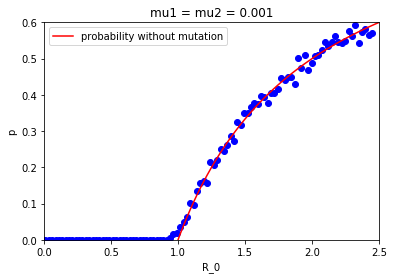

In [1365]:
#plot the result of the previous cell
plt.plot(RRR_0, ppp, "ob")

#graph actual probability of outbreak
plt.plot(RRR_0, 1-1/RRR_0, "r", label='probability without mutation')

plt.title('mu1 = mu2 = 0.001')
plt.xlabel("R_0")
plt.ylabel("p")
plt.xlim(0, 2.5)
plt.ylim(0, 0.6)
plt.legend()
plt.show()

The next two cells plot percentage of outbreaks against R_0, when mu_1 = mu_2 = 0.01

In [1366]:
# This cell takes several minutes to run.

mu_1 = 0.01
mu_2 = 0.01

# Take a some evenly spaced R_0 values from 0.01 to 2.5
beta_range = np.linspace(0.001, 0.25, 100)
gamma = 0.1

RR_0 = []
pp = []

#simulate percentages of outbreak
for beta in beta_range:
    RR_0 = np.append(RR_0, beta/gamma)
    pp = np.append(pp, sim_percentage(beta, gamma, mu_1, mu_2, N_sims=1000))

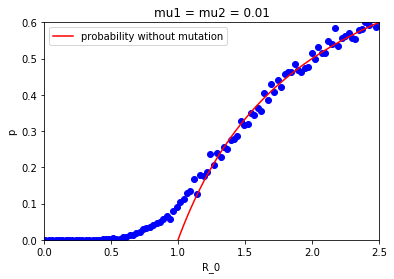

In [1367]:
#plot the result of the previous cell
plt.plot(RR_0, pp, "ob")

#graph actual probability of outbreak
plt.plot(RR_0, 1-1/RR_0, "r", label='probability without mutation')

plt.title('mu1 = mu2 = 0.01')
plt.xlabel("R_0")
plt.ylabel("p")
plt.xlim(0, 2.5)
plt.ylim(0, 0.6)
plt.legend()
plt.show()

The next two cells plot percentage of outbreaks against R_0, when mu_1 = mu_2 = 0.1

In [1373]:
# This cell takes several minutes to run.

mu_1 = 0.1
mu_2 = 0.1

# Take a some evenly spaced R_0 values from 0.01 to 2.5
beta_range = np.linspace(0.001, 0.25, 100)
gamma = 0.1

R_0 = []
p = []

#simulate percentages of outbreak
for beta in beta_range:
    R_0 = np.append(R_0, beta/gamma)
    p = np.append(p, sim_percentage(beta, gamma, mu_1, mu_2, N_sims=1000))

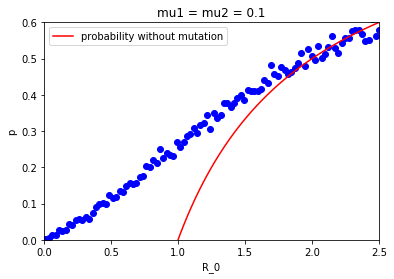

In [1374]:
#plot the result of the previous cell
plt.plot(R_0, p, "ob")

#graph actual probability of outbreak
plt.plot(R_0, 1-1/R_0, "r", label='probability without mutation')

plt.title('mu1 = mu2 = 0.1')
plt.xlabel("R_0")
plt.ylabel("p")
plt.xlim(0, 2.5)
plt.ylim(0, 0.6)
plt.legend()
plt.show()

Here is some more space to play with different values of mu_1 and mu_2

In [1370]:
#parameters
beta_0 = 0.09
gamma_0 = 0.1
mu_1 = 0.01
mu_2 = 0.01

sim_percentage(beta_0, gamma_0, mu_1, mu_2, N_sims=10000)

0.0658

The next three cells generate some more graphs and visualizations.
Specifically:
    - run simulations WITHOUT recurrent spillover until we get an outbreak.
    - plot beta and gamma over time.
    - plot infecteds over time.

In [1243]:
#############################################################
# version of sim which returns picture plotting information #
#############################################################
#
# returns boolean, times, betas, gammas, N_infecteds
# boolean is 0 if extinction, 1 if outbreak
# all the others are arrays of the same length. 
# "times" is all the times of new infections. the others are corresponding values. 
# 
# TO DO: turn this return value into a class. rewrite stuff, then maybe replace sim with this function.
# TO DO: define protocol complete_sim_until_time(t, infecteds)
#     even if we have an outbreak, there will still be unbranched people that may have branched before the time of outbreak.
#     complete all the branching up until the time of the outbreak.
#############################################################

def sim_plots(beta_0, gamma_0, mu_1=0, mu_2=0):
    
    outbreak_thresh = 100 #call it an outbreak if this many people are infected
    
    #stuff to fill and return
    times = np.array([0])
    betas = np.array([beta_0])
    gammas = np.array([gamma_0])
    N_infecteds = np.array([1])
    
    #will do this stuff right before we return
    def sort_by_times(boolean, times, betas, gammas, N_infecteds):
        
        #sort 3 of the 4 return arrays in increasing order of time.
        #N_infecteds is the only one that does not need to get sorted.
        sorted_indices = np.argsort(times)
        times = times[sorted_indices]
        betas = betas[sorted_indices]
        gammas = gammas[sorted_indices]
        
        return boolean, times, betas, gammas, N_infecteds 
    
    #store active cases as an array of triples
    #each triple looks like [beta, gamma, time of infection] and represents one infected person
    infecteds=np.array([[beta_0, gamma_0, 0]])

    N_infected = 1 #keep track of number of infected people. 
    
    while True: 
        
        #print("\n", "infecteds now = ", infecteds)
        
        person = infecteds[0] #branch person 0. note infecteds is maintained in order of increasing time of infection, so this is the earliest infected person available.
        [beta, gamma, t] = person
        #print("\n", "branching person who was infected at time", t)

        while True:
            
            #we might sometimes run into a person with beta = gamma = 0, as a result of mutation. 
            #in this case the next part would throw a divide by 0 error. 
            #this is a person who never transmits and never recovers, so we should just delete them
            #we also subtract 1 from N_infected, in order to avoid throwing other errors. maybe think of a better way to deal with this in the future.
            if beta == 0 and gamma == 0:
                
                print('deleting someone with beta=gamma=0')
                
                infecteds = np.delete(infecteds, 0, axis=0)
                N_infected -= 1
                
                #if this was the last person, declare the infection extinct
                #(if we tried to iterate again it would throw an error)
                if N_infected == 0:
                    t_ext = new_t
                    return [0, t_ext]
                break #skip to next person

            #interevent time
            #note this is interevent time for ONE person, NOT for entire population
            dt = np.random.exponential(scale=1/(beta + gamma))
            new_t = t + dt

            #pick which event happens, transmission or recovery         
            ev = np.random.rand() #draw number from uniform distribution over [0, 1)
            prob_trans = beta / (beta+gamma) #probability of transmission

            if (ev < prob_trans): #transmission

                #print("transmitting")

                #pick beta and gamma for new case
                #mutation is a number drawn from normal distribution with std dev mu_1 or mu_2
                #don't allow negative beta or gamma
                mut1 = np.random.normal(loc=0.0, scale=mu_1)
                new_beta = max(0, beta + mut1)
                mut2 = np.random.normal(loc=0.0, scale=mu_2)
                new_gamma = max(0, gamma + mut2)
                
                #append new person to array of infecteds
                infecteds = np.append(infecteds, [[new_beta, new_gamma, new_t]], axis=0)
                
                #print("new infection: ", [new_beta, new_gamma, new_t])

                N_infected += 1
                
                #update return arrays
                times = np.append(times, new_t)
                betas = np.append(betas, new_beta)
                gammas = np.append(gammas, new_gamma)
                N_infecteds = np.append(N_infecteds, N_infected)

                #check if we have an outbreak
                if N_infected >= outbreak_thresh:
                    
                    #print("\n", "outbreak!")
                    
                    return sort_by_times(1, times, betas, gammas, N_infecteds)

            else: #recovery

                #print("recovering") 

                N_infected -= 1

                #check if we have extinction       
                if N_infected == 0:
                    t_ext = new_t #time of extinction
                    
                    #print("\n", "extinction")
                    
                    return sort_by_times(0, times, betas, gammas, N_infecteds)

                #delete the person 
                infecteds = np.delete(infecteds, 0, axis=0)
                break #skip to next person

            #sort the array of infecteds in increasing order of time infected. 
            sorted_indices = np.argsort(infecteds[:,2])
            infecteds = infecteds[sorted_indices]           

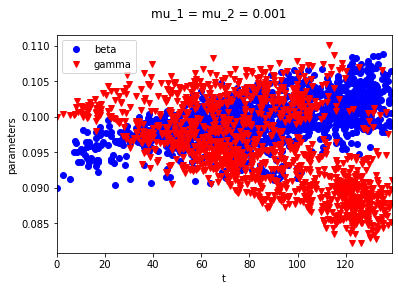

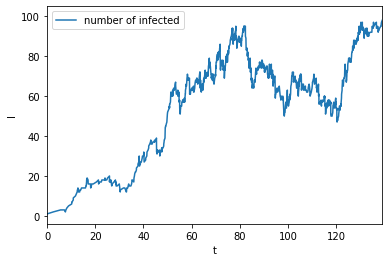

In [1494]:
#parameters
beta_0 = 0.09
gamma_0 = 0.1
mu_1 = 0.001
mu_2 = 0.001

while True:
    boolean, times, betas, gammas, N_infecteds = sim_plots(beta_0, gamma_0, mu_1, mu_2)
    if boolean==1: break

max_time=max(times)

#plot betas and gammas over time
plt.plot(times, betas, "ob", label='beta')
plt.plot(times, gammas, "vr", label='gamma')
plt.suptitle('mu_1 = mu_2 = 0.001')
plt.xlabel("t")
plt.ylabel("parameters")
plt.xlim(0, 0.9*max_time)
plt.legend()
plt.show()

#plot N_infecteds over times
plt.plot(times, N_infecteds, label='number of infected')
plt.xlabel("t")
plt.ylabel("I")
plt.xlim(0, 0.9*max_time)
plt.legend()
plt.show()

Simulations WITH Recurrent Spillover

In [1358]:
################################################
# simulates infection WITH recurrent spillover #
################################################
#
# input alpha = spillover rate.
#
# inputs beta_0, gamma_0, mu_1, mu_2 are the same as in the function sim from above
#
# there are two hidden inputs max_t_ext, t_s, which you should ignore. (do NOT pass in any values for these.)
# they are only used implicitly when this function recursively calls itself.
#
################################################
#
# returns 1 if outbreak
# returns 0 if extinction
#
################################################

def recurrent_sim(alpha, beta_0, gamma_0, mu_1=0.001, mu_2=0.001, max_t_ext=0, t_s=0): 
    
    #print("max_t_ext = ", max_t_ext)
    
    # hidden input max_t_ext keeps track of maximum extinction time seen so far
    # hidden input t_s keeps track of most recent time of spillover
    
    # simulate tree from a new spillover event
    sim_output = sim(beta_0, gamma_0, mu_1, mu_2)

    # if simulation outbreaks, we are done
    if sim_output == [1]:
        
        #print("\n", "outbreak!")
        return 1
    
    # otherwise, that tree goes extinct
    # but we need to check whether any other spillovers have happened
    else:
        
        #print("max_t_ext updating, = max of ", max_t_ext, "and", sim_output[1])
        max_t_ext = max(max_t_ext, sim_output[1]) #update max extinction time, if necessary
        
        #generate time of next spillover
        dt_s = np.random.exponential(scale=1/alpha) #inter-spillover time
        t_s += dt_s #time of next spillover
        #print("time of spillover is t_s = ", t_s)

        # if spillover occurs soon enough, we have to simulate another tree. recurse.
        if t_s < max_t_ext: 
            
            #print("a spillover occured! Recursing...")
            return recurrent_sim(alpha, beta_0, gamma_0, mu_1, mu_2, max_t_ext, t_s)

        # if spillover occurs too late, we are done.
        else: 
            
            #print("next spillover too late. extinction!")
            return 0

In [1359]:
####################################################
# run a single simulation WITH recurrent spillover #
####################################################

#parameters
alpha = 0.1
beta_0 = 0.09
gamma_0 = 0.1

recurrent_sim(alpha, beta_0, gamma_0)

0

In [1395]:
##################################################
# runs many simulations WITH recurrent spillover #
##################################################
#
# returns the percentage of them that outbreak
#
##################################################

def recurrent_sim_percentage(alpha, beta_0, gamma_0, mu_1 = 0.01, mu_2 = 0.01, N_sims=100): 
    N_outbreaks = 0
    for i in range(N_sims):
        if recurrent_sim(alpha, beta_0, gamma_0, mu_1, mu_2) == 1: 
                N_outbreaks += 1
    return N_outbreaks/N_sims

In [1396]:
##################################################
# run a bulk simulation WITH recurrent spillover #
##################################################

#parameters
alpha = 0.7
beta_0 = 0.09
gamma_0 = 0.1

recurrent_sim_percentage(alpha, beta_0, gamma_0, mu_1=0.001, mu_2=0.001)

0.09

In [1499]:
#plot percentage of outbreaks vs alpha (other parameters fixed)

#parameters
beta_0 = 0.09
gamma_0 = 0.1
mu_1 = 0.001
mu_2 = 0.001

max_alpha = 1

alphas=np.linspace(0.001, max_alpha, 20)
percentages = []

for alpha in alphas:
    percentages = np.append(
        percentages, recurrent_sim_percentage(
            alpha, beta_0, gamma_0, mu_1, mu_2, N_sims=500))   
    

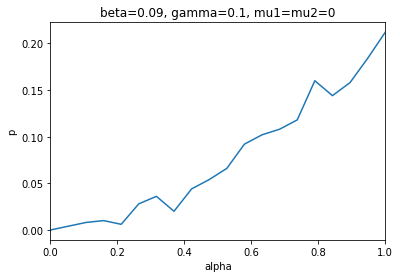

In [1500]:
plt.plot(alphas, percentages)
plt.title('beta=0.09, gamma=0.1, mu1=mu2=0')
plt.xlabel('alpha')
plt.ylabel('p')                      
#plt.ylim(-.1,1.1)
plt.xlim(0, max_alpha)
plt.show()